In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Bidirectional, CuDNNLSTM, Reshape, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

import os

from PIL import Image

Using TensorFlow backend.


In [2]:
def load_data():
        x_train = np.load(r'C:\Users\Vee\Desktop\python\GAN\Music GAN\answers.npy',allow_pickle=True)
        x_train = x_train.reshape(len(x_train),4,4)
        return x_train

In [3]:
class LSTMGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 4
        self.img_cols = 4
        self.img_shape = (self.img_rows, self.img_cols)
        self.latent_dim = 16

        optimizer = Adam(0.0001, 0.4)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(4,4))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        #encoder
        model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True), input_shape=(4, 4)))
        model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
        model.add(Bidirectional(CuDNNLSTM(256)))
        #specifying output to have 16 timesteps
        model.add(RepeatVector(16))
        #decoder
        model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
        model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
        model.add(TimeDistributed(Dense(256)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(256)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(1)))
        model.add(LeakyReLU(alpha=0.2))
        model.summary()

        noise = Input(shape=(4,4))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True), input_shape=(16, 1)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Bidirectional(CuDNNLSTM(256)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(RepeatVector(1))
        model.add(TimeDistributed(Dense(256)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(256)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(256)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(TimeDistributed(Dense(1)))
        model.summary()

        img = Input(shape=(16,1))
        validity = model(img)

        return Model(img, validity)
    

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train = load_data()

        # Rescale -1 to 1
        X_train = X_train / 128

        # Adversarial ground truths
        valid = np.ones((batch_size,1,1))
        fake = np.zeros((batch_size,1,1))
        
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            imgs = np.array(imgs)
            imgs = imgs.reshape(len(imgs),16,1)

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size,4,4))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)
            
            #save loss history
            g_loss_epochs[epoch] = g_loss
            d_loss_epochs[epoch] = d_loss[0]

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.generator.save("LSTM_generator2.h5")
        return g_loss_epochs, d_loss_epochs

In [4]:
lstmgan = LSTMGAN()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 16, 512)           530432    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 512)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1576960   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 512)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 256)           

In [5]:
g_loss, d_loss = lstmgan.train(epochs=101, batch_size=40, save_interval=100)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 5.725701, acc.: 50.00%] [G loss: 5.433469]


C:\Users\Vee\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 2.694293, acc.: 50.00%] [G loss: 5.073631]
2 [D loss: 2.594620, acc.: 50.00%] [G loss: 4.943325]
3 [D loss: 2.559330, acc.: 50.00%] [G loss: 4.784934]
4 [D loss: 2.469940, acc.: 50.00%] [G loss: 4.606302]
5 [D loss: 2.404938, acc.: 50.00%] [G loss: 4.520539]
6 [D loss: 2.354054, acc.: 50.00%] [G loss: 4.211426]
7 [D loss: 2.327359, acc.: 50.00%] [G loss: 3.896049]
8 [D loss: 2.302319, acc.: 50.00%] [G loss: 3.837500]
9 [D loss: 2.268051, acc.: 50.00%] [G loss: 3.347299]
10 [D loss: 2.203280, acc.: 50.00%] [G loss: 3.016977]
11 [D loss: 2.170610, acc.: 50.00%] [G loss: 2.740844]
12 [D loss: 2.105887, acc.: 50.00%] [G loss: 5.048566]
13 [D loss: 2.015707, acc.: 50.00%] [G loss: 6.053413]
14 [D loss: 1.950363, acc.: 50.00%] [G loss: 5.357563]
15 [D loss: 1.869085, acc.: 50.00%] [G loss: 4.650980]
16 [D loss: 1.841916, acc.: 50.00%] [G loss: 3.980913]
17 [D loss: 1.748857, acc.: 50.00%] [G loss: 3.583301]
18 [D loss: 1.645131, acc.: 50.00%] [G loss: 3.956760]
19 [D loss: 1.54814

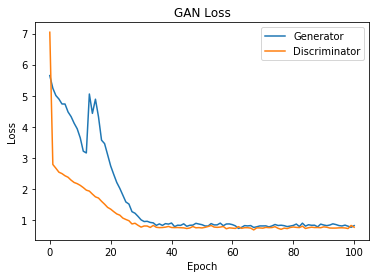

In [11]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Generator', 'Discriminator'], loc='upper right')
plt.show()